In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib.patches import FancyArrow
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import socceraction
import socceraction.spadl as spadl

In [2]:
fe = fm.FontEntry(
    fname='/Users/davidegualano/Documents/Python FTBLData/SourceSansPro-Regular.ttf',
    name='SourceSansPro-Regular'
)
fm.fontManager.ttflist.insert(0, fe)
matplotlib.rcParams['font.family'] = fe.name

In [3]:
teams0 = pd.read_csv("teams2021.csv", index_col = 0)
teams1 = pd.read_csv("teams2122.csv", index_col = 0)
teams2 = pd.read_csv("teams2223.csv", index_col = 0)
teams3 = pd.read_csv("teams2324.csv", index_col = 0)

players0 = pd.read_csv("players2021.csv", index_col = 0)
players1 = pd.read_csv("players2122.csv", index_col = 0)
players2 = pd.read_csv("players2223.csv", index_col = 0)
players3 = pd.read_csv("players2324.csv", index_col = 0)

actions0 = pd.read_csv("actions2021.csv", index_col = 0)
actions1 = pd.read_csv("actions2122.csv", index_col = 0)
actions2 = pd.read_csv("actions2223.csv", index_col = 0)
actions3 = pd.read_csv("actions2324.csv", index_col = 0)

teams = pd.concat([teams0, teams1, teams2, teams3])
players = pd.concat([players0, players1, players2, players3])
actions = pd.concat([actions0, actions1, actions2, actions3])

actions.drop(columns=['action_id'], inplace=True)
actions.reset_index(drop=True, inplace=True)
actions.reset_index(inplace=True)
actions.rename(columns={'index': 'action_id'}, inplace=True)

In [4]:
teams = teams.drop_duplicates()

In [5]:
actions = spadl.add_names(actions)

In [6]:
dfb = (actions
       .merge(players, how="left")
       .merge(teams, how="left")
      )

In [7]:
dfb["beginning_distance"] = np.sqrt(np.square(105-dfb['start_x_a0']) + np.square(34-dfb['start_y_a0'])).round(2)
dfb["end_distance"] = np.sqrt(np.square(105-dfb['end_x_a0']) + np.square(34-dfb['end_y_a0'])).round(2)
dfb["length"] = dfb["end_distance"] - dfb["beginning_distance"]
dfb['length'] = dfb['length'].abs()
dfb["angle"] = np.arctan2(dfb["end_y_a0"] - dfb["start_y_a0"], dfb["end_x_a0"] - dfb["start_x_a0"])
dfb['angle_degrees'] = np.degrees(dfb['angle']) % 360
dfb['angle'] = dfb['angle'] % (2 * np.pi)  # Ensure angles are between 0 and 2π

In [8]:
def format_season_id(season_id):
    # Convert to integer if it's a float
    season_id = int(season_id)
    # Extract the last two digits of the year
    start_year = str(season_id -1)[-2:]
    # Calculate the end year
    end_year = str(season_id)[-2:]
    # Format as 20/21
    formatted_season = f"{start_year}/{end_year}"
    return formatted_season

In [9]:
passes = dfb[dfb["type_name"] == 'pass']

In [28]:
P0 = passes[passes["player_name"] == 'Benjamin Pavard']
P0.team_name.unique()

array(['Bayern', 'Inter'], dtype=object)

In [29]:
P1 = P0[P0["team_name"] == "Inter"]

In [30]:
P1['formatted_season'] = P1['season_id'].apply(format_season_id)
P1.season_id.unique()

/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_11434/438652562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P1['formatted_season'] = P1['season_id'].apply(format_season_id)


array([2324.])

In [31]:
P = P1[P1["season_id"] == 2324.]

In [32]:
def calculate_segments_per_ring(rings, blocks_in_first_ring, radius_step):
    radii = np.arange(0, radius_step * (rings + 1), radius_step)
    
    # Calculate the area difference for each ring
    area_differences = np.diff(radii**2)
    
    # Calculate the number of segments (blocks) per ring
    segments_per_ring = np.round(area_differences / (area_differences[0] / blocks_in_first_ring)).astype(int)
    
    return segments_per_ring

def plot_sonar(passes, rings=10, blocks_in_first_ring=4, pitch_length=105, zoom_factor=None, title=None, subtitle=None, endnote=None):
    # Calculate the radius step (distance covered by each ring)
    radius_step = pitch_length / rings
    
    # Automatically calculate the number of segments per ring
    segments_per_ring = calculate_segments_per_ring(rings, blocks_in_first_ring, radius_step)
    
    fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': 'polar'})
    
    max_length = pitch_length  # Set the max length to the pitch length (105 meters)
    
    # Scaling factors for each ring; adjust these as needed
    scaling_factors = np.linspace(1.5, 0.2, rings)  # Higher scaling for inner rings, lower for outer
    
    for i in range(rings):
        segments = segments_per_ring[i]
        ring_passes = passes[(passes['length'] >= radius_step * i) & (passes['length'] < radius_step * (i + 1))]
        max_passes_in_ring = ring_passes.shape[0]
        
        for j in range(segments):
            angle_min = j * 2 * np.pi / segments
            angle_max = (j + 1) * 2 * np.pi / segments
            angle_width = angle_max - angle_min
            
            # Define the radius range for this block
            radius_min = radius_step * i
            radius_max = radius_step * (i + 1)
            
            # Filter passes that fall into this segment
            segment_passes = ring_passes[(ring_passes['angle'] >= angle_min) &
                                         (ring_passes['angle'] < angle_max)]
            
            if len(segment_passes) > 0:
                # Adjust thickness based on the number of passes and the scaling factor for the ring
                thickness_adjustment = scaling_factors[i] * np.sqrt(len(segment_passes) / max_passes_in_ring)
                radius_inner_adjusted = max(radius_max - (radius_step * thickness_adjustment), radius_min + radius_step * 0.1)
                
                # Success rate determines the color
                success_rate = (segment_passes['result_name'] == 'success').mean()
                color = plt.cm.YlOrRd(success_rate)  # Adjust color mapping
                
                # Plot the segment with adjusted inner radius
                ax.bar(x=angle_min, height=radius_max - radius_inner_adjusted, width=angle_width,
                       bottom=radius_inner_adjusted, color=color, edgecolor='black', linewidth=1.0)
    
    # Remove extra padding around the plot
    ax.margins(0)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # Customize plot appearance
    ax.set_theta_zero_location('N')  # 0 degrees at the top (South)
    ax.set_theta_direction(1)  # Counterclockwise direction
    ax.set_ylim(0, pitch_length)  # Set the radial limit to the length of the pitch
    ax.grid(False)  # Remove grid lines
    ax.set_facecolor('#111111')  # Set background color to dark
    ax.set_yticklabels([])  # Remove radial ticks
    ax.set_xticklabels([])  # Remove angular ticks
    
    # Add the arrow indicating direction of play on the side of the plot
    arrow_ax = fig.add_axes([0.78, 0.25, 0.03, 0.5])  # Position [left, bottom, width, height]
    arrow_ax.add_patch(FancyArrow(0.5, 0.1, 0, 0.8, width=0.1, head_width=0.3, head_length=0.1, color='#000000'))
    arrow_ax.set_xlim(0, 1)
    arrow_ax.set_ylim(0, 1)
    arrow_ax.axis('off')  # Hide the axis

    # Add title and subtitle
    if title:
        plt.text(0.5, 1.05, title, ha='center', va='bottom', transform=ax.transAxes, color='#000000', fontsize=25)
    
    if subtitle:
        plt.text(0.5, 1.02, subtitle, ha='center', va='bottom', transform=ax.transAxes, color='#000000', fontsize=15)
    
    # Add endnote
    if endnote:
        plt.text(0.5, -0.02, endnote, ha='center', va='top', transform=ax.transAxes, color='#000000', fontsize=10)

    return fig, ax  # Return the figure and axis objects for further use

In [33]:
A = P.groupby(["result_name"], observed=True).size().reset_index(name='count')
A['total'] = P.result_name.count()
A['percent'] = ((A['count']*100) /A['total']).round(1)

In [34]:
A

,result_name,count,total,percent
0,fail,136,1573,8.6
1,offside,3,1573,0.2
2,success,1434,1573,91.2


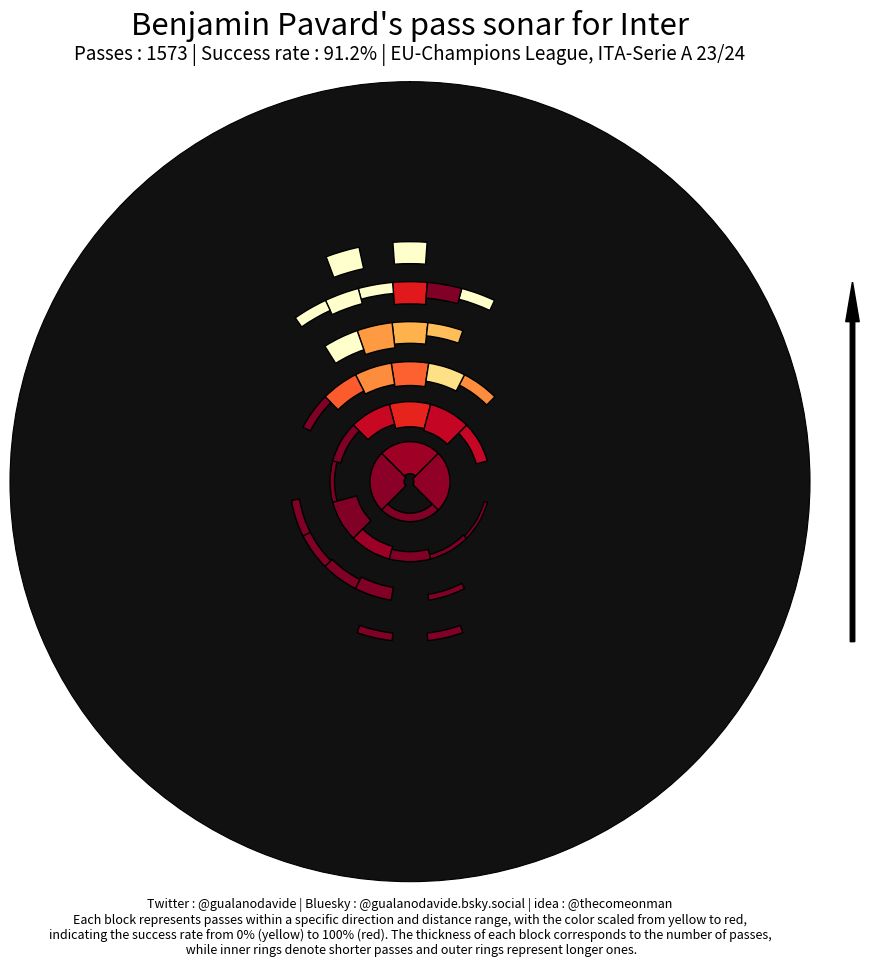

In [35]:
nrows = P.shape[0]
# Loop through each row in the dataframe
for y in range(nrows):
    titley = P['player_name'].iloc[y]
    titlex = P['season_id'].iloc[y]
    
# Generate the plot
fig, ax = plot_sonar(
    P, pitch_length=105,
    title=f"{titley}'s pass sonar for {P.team_name.iloc[y]}",
    subtitle = f"Passes : {P['type_name'].count()} | Success rate : {(((P['result_name'] == 'success').mean())*100).round(1)}% | {', '.join(P['competition_id'].unique())} {P.formatted_season.iloc[y]}",
    endnote="Twitter : @gualanodavide | Bluesky : @gualanodavide.bsky.social | idea : @thecomeonman\nEach block represents passes within a specific direction and distance range, with the color scaled from yellow to red,\nindicating the success rate from 0% (yellow) to 100% (red). The thickness of each block corresponds to the number of passes,\n while inner rings denote shorter passes and outer rings represent longer ones."
)

# Save the plot immediately after generation
fig.savefig(f'{titley}-Passsonar-{titlex}.png', dpi=500, facecolor="#D7D1CF", bbox_inches="tight")

# Show the plot (you may want to comment this out if you're saving many plots)
plt.show()

In [122]:
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import urllib
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patches import RegularPolygon
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
from mplsoccer import Pitch, VerticalPitch, lines

In [180]:
P["avantiindietro"] = P["end_distance"] - P["beginning_distance"]
P2 = P[P["angle_degrees"] == 270]

/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_8981/1592565744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P["avantiindietro"] = P["end_distance"] - P["beginning_distance"]


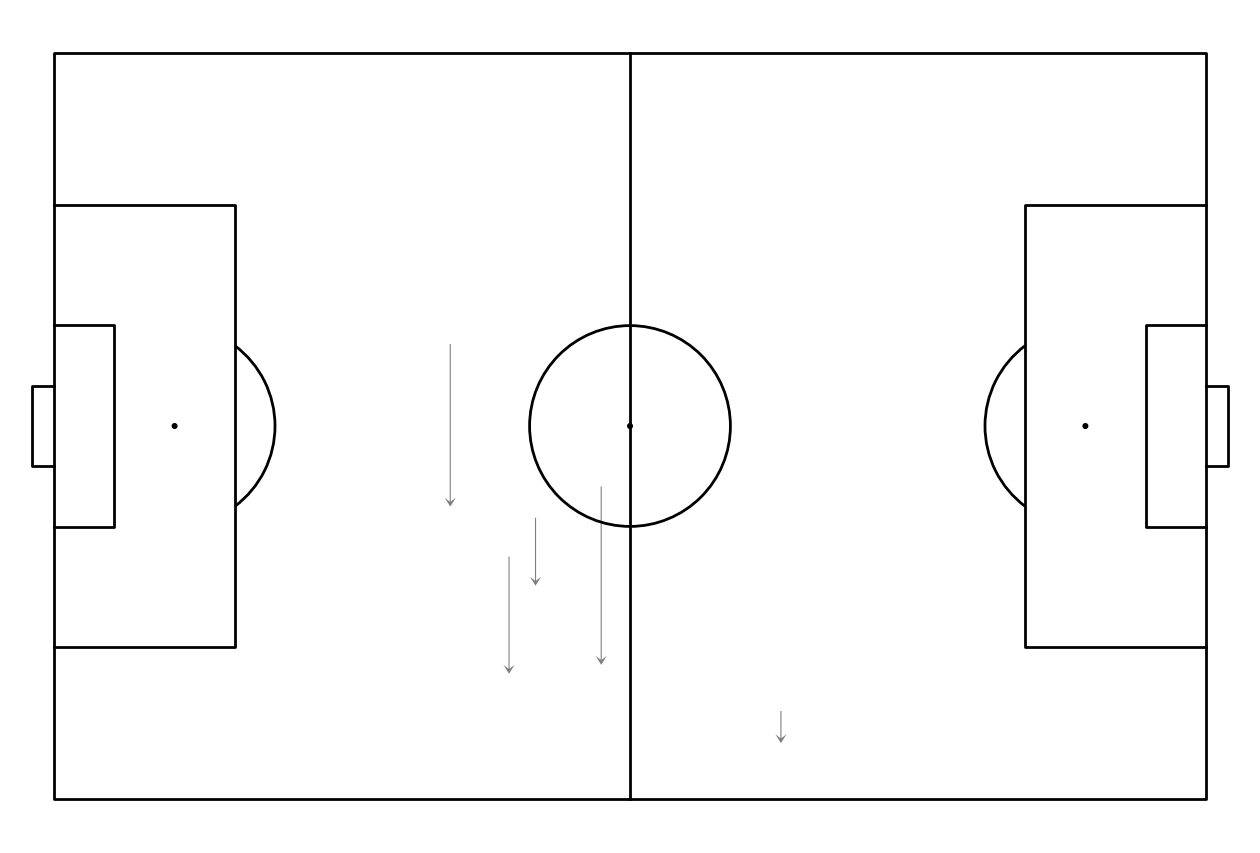

In [181]:
pitch = Pitch(pitch_type='uefa', goal_type='box', linewidth=2, line_color='black', half=False)
bins = (6, 5)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

# plot the pass flow map with a single color ('black') and length of the arrow (5)
am = pitch.arrows(P2.start_x_a0, P2.start_y_a0, P2.end_x_a0, P2.end_y_a0, width=0.8, alpha = 0.5, zorder = 1,
             headwidth = 10, headlength = 8, color = '#000000', label = 'successful passes', ax=ax)